In [673]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import c_
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

sns.reset_orig()

NOISE = 16
SAMPLES = 2425
SEED = 24482
CLASSES = 2
TRAIN_SPLIT = 0.8
TEST_SPLIT = 0.2
REPEATS = 100

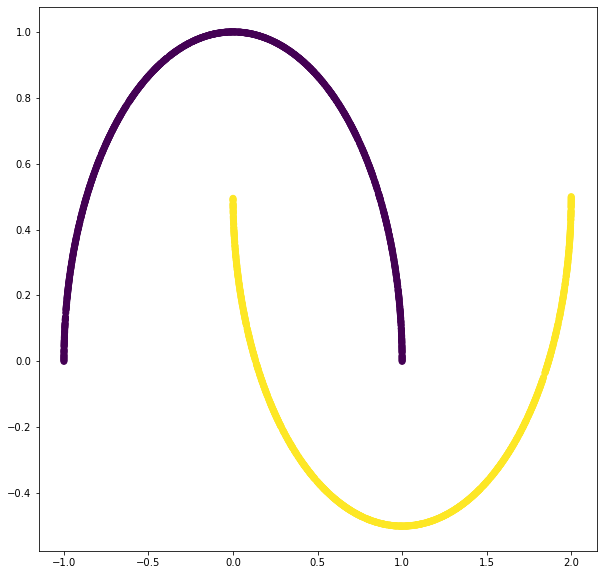

In [674]:
X, y = datasets.make_moons( random_state=SEED, n_samples=SAMPLES)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SPLIT, test_size=TEST_SPLIT,
                                                    random_state=SEED)

y_test2 = np.copy(y_test)
y_train2 = np.copy(y_train)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                     np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10, 10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [675]:
# X, y = datasets.make_moons(random_state=SEED, n_samples=SAMPLES, noise=0.05)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SPLIT, test_size=TEST_SPLIT,
#                                                     random_state=SEED, shuffle=True, stratify=y)
#
# xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
#                      np.arange(X.min(), X.max(), 0.01))
#
# y_test2 = np.copy(y_test)
#
# y_train2[y_train2 == 0] = -1
#
# plt.figure(figsize=(10, 10))
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

#         self.weights_input_to_hidden = np.array([
#             [0.1, 0.1, -.3], [.1, .2, 0.0], [.0, .7, .1], [.2, .4, .0], [-.3, .5, .1]
#         ])

In [676]:
from abc import ABC, abstractmethod


class AbstractActivationFunction(ABC):
    @abstractmethod
    def __init__(self, name, function, derivative):
        raise NotImplementedError

    @abstractmethod
    def __str__(self):
        raise NotImplementedError

    @abstractmethod
    def __call__(self, x, derivative=False):
        raise NotImplementedError

In [677]:
from sklearn.preprocessing import OneHotEncoder


class MyNeuralNetwork:

    class ActivationFunction(AbstractActivationFunction):
        def __init__(self, name, function, derivative):
            self.name = name
            self.function = function
            self.derivative = derivative

        def __str__(self):
            return self.name

        def __call__(self, x, derivative=False):
            if derivative:
                return self.derivative(x)
            else:
                return self.function(x)

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate=0.01, activation_function: AbstractActivationFunction=None, random_state=None, epochs=100):
        self.n_inputs = n_inputs + 1
        self.hidden_layer_size = n_hidden
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.epochs = epochs

        if activation_function:
            self.activation_function = activation_function
        else:
            self.activation_function = self.ActivationFunction(name="sigmoid",
                                                               function=lambda x: 1 / (1 + np.exp(-x)),
                                                               derivative=lambda x: 1 / (1 + np.exp(-x) * (1 - 1 / (1 + np.exp(-x)))
                                                                )
                                                                )
            # self.activation_function = self.ActivationFunction(name="relu",
            #                                                    function=lambda x: np.maximum(0, x),
            #                                                    derivative=lambda x: np.where(x > 0, 1, 0))

        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_layer_size ** -0.5,
                                                        (self.hidden_layer_size, self.n_inputs))

        # self.weights_input_to_hidden = np.array([
        #     [0.1, 0.1, -.3], [.1, .2, 0.0], [.0, .7, .1], [.2, .4, .0], [-.3, .5, .1]
        # ])

        self.weights_hidden_to_output = np.random.normal(0.0, self.n_outputs ** -0.5,
                                                         (self.n_outputs, self.hidden_layer_size))

        # self.weights_hidden_to_output = np.array([
        #     [0.7, 0.9, -0.4, 0.8, 0.1],
        #     [0.8, 0.5, 0.3, 0.1, 0.0],
        #     [-0.3, 0.9, 0.3, 0.1, -0.2]
        # ])

        #print(self.weights_input_to_hidden)
        #print(self.weights_hidden_to_output)

    def fit(self, X, y):
        X = np.array(X)
        bias = np.ones((X.shape[0], 1)) * -1
        X = np.column_stack((X, bias))
        X = X.T
        y = np.array(y)

        for e in tqdm(range(self.epochs)):
            output_layer_output, hidden_layer_output = self.forward_pass(X)
            #print(hidden_layer_output, '\n', output_layer_output)
            output_layer_delta, hidden_layer_delta = self.backward_pass(X, y, output_layer_output, hidden_layer_output)
            # print(output_layer_delta, '\n', hidden_layer_delta)
            self.update_weights(hidden_layer_delta, output_layer_delta)
            #print(self.weights_input_to_hidden, '\n', self.weights_hidden_to_output)
        pass

    def forward_pass(self, X):
        hidden_layer_input = np.dot(self.weights_input_to_hidden, X)
        hidden_layer_output = self.activation_function(hidden_layer_input)

        output_layer_input = np.dot(self.weights_hidden_to_output, hidden_layer_output)
        output_layer_output = self.activation_function(output_layer_input)

        return output_layer_output, hidden_layer_output

    def backward_pass(self, X, y, output_layer_output, hidden_layer_output):
        # error_output_layer = 2 * (1 / 3) * (y_output - y1) / 4
        # output layer error
        output_layer_error = 2 * (output_layer_output - y) / X.shape[0]
        output_layer_delta = output_layer_error @ hidden_layer_output.T
        # hidden layer error
        #mnn.weights_hidden_to_output.T @ error_output_layer
        hidden_layer_error = self.weights_hidden_to_output.T @ output_layer_error
        hidden_layer_delta = hidden_layer_error * self.activation_function(hidden_layer_output, derivative=True) @ X.T

        return output_layer_delta, hidden_layer_delta

    def update_weights(self, delta_at_hidden_layer, delta_at_output_layer):
        # update weights between hidden and output layer
        self.weights_hidden_to_output -= (self.learning_rate * delta_at_output_layer)


        # print(self.weights_hidden_to_output)
        # update weights between input and hidden layer
        self.weights_input_to_hidden -= (self.learning_rate * delta_at_hidden_layer)

    def predict(self, X):
        X = np.array(X)
        bias = np.ones((X.shape[0], 1)) * -1
        X = np.column_stack((X, bias))
        X = X.T
        outy, outh = self.forward_pass(X)
        return np.where(outy >= 0.5, 1, 0)

    def predict_proba(self, X):
        X = np.array(X)
        bias = np.ones((X.shape[0], 1)) * -1
        X = np.column_stack((X, bias))
        X = X.T
        outy, outh = self.forward_pass(X)
        return outy

    def score(self, X, y):
        pass




In [678]:
class Relu:
    def __call__(self, x, derivative=False):
            if derivative:
                return np.where(x > 0, 1, 0)
            else:
                return np.maximum(0, x)

relu = Relu()

In [679]:
mnn = MyNeuralNetwork(3, 5, 1)

In [680]:
ith = mnn.weights_input_to_hidden
x1 = np.array([[0.5, 0.1, .2, .8], [.75, .3, .1, .9], [.1, .7, .6, .2]])
y1 = np.array([[.1, .5, .1, .7], [1.0, .2, .3, .6], [.1, -.5, .2, .2]])
zzz = np.array(ith @ x1)
lay_out = relu(zzz)
print(zzz)
lay_out

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 4)

In [ ]:
y_output = mnn.weights_hidden_to_output @ lay_out
y_output

In [ ]:
error_output_layer = 2 * (1 / 3) * (y_output - y1) / 4
print(y1)
error_output_layer

In [ ]:
# h_delta = mnn.weights_input_to_hidden @ lay_out
# h_delta

In [ ]:
out_delta = error_output_layer @ lay_out.T
out_delta

In [ ]:
mnn.weights_hidden_to_output - (0.1 * out_delta)

In [ ]:
print(mnn.weights_hidden_to_output.T, '\n', error_output_layer)
hid_err = mnn.weights_hidden_to_output.T @ error_output_layer
# hid_delt = hid_err @ x1.T
hid_err

In [ ]:
# print(mnn.weights_input_to_hidden, '\n', hid_delt)
# (mnn.weights_input_to_hidden - (0.1 * hid_delt))

In [ ]:
mnn.fit(x1, y1)

In [ ]:
mnn = MyNeuralNetwork(2, 10, 1)
mnn.fit(X_train.T, y_train)

In [ ]:
y_pred = mnn.predict(X_test)
y_pred

In [699]:
def tree_function(mdl, X_tr, y_tr, X_te, y_te, xxx=None, yyy=None, silent=False):

    mdl.fit(X_tr, y_tr)

    y_pred = mdl.predict(X_te).flatten()
    # print(y_pred.shape, y_te.shape)

    if silent == False:
        mesh_data = c_[xxx.ravel(), yyy.ravel()]
        Z = np.asarray(mdl.predict(mesh_data)).reshape(xx.shape)

        plt.figure(figsize=(10, 10))
        plt.contourf(xx, yy, Z, alpha=0.6, cmap = 'ocean')
        plt.scatter(X_te[:, 0], X_te[:, 1], c=y_te)

        cm_model = confusion_matrix(y_te, y_pred)
        tn_model = cm_model[0][0]
        fn_model = cm_model[0][1]
        tp_model = cm_model[1][1]
        fp_model = cm_model[1][0]
        ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

        fpr, tpr, roc_auc = roc_curve(y_te, y_pred)

        rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
        rok_model.plot()


        print("Czulosc:", tp_model/(tp_model + fn_model))
        print("Swoistosc:", tn_model/(tn_model + fp_model))
        print("Accuracy:", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

        print("ROC auc:", roc_auc_score(y_test, y_pred))
        print("F1 score:", f1_score(y_test, y_pred))
        print("BA score:", balanced_accuracy_score(y_test, y_pred))

100%|██████████| 10000/10000 [00:05<00:00, 1790.61it/s]


Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0


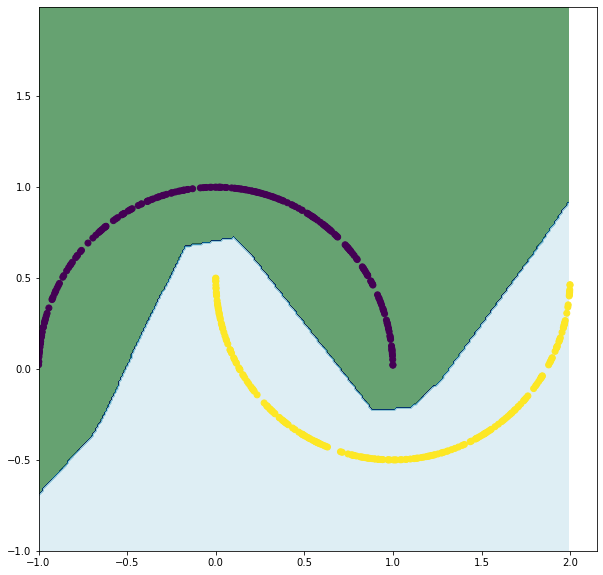

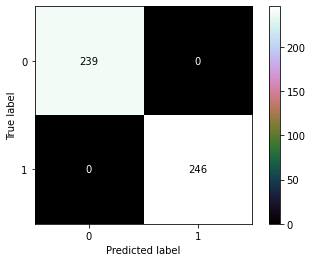

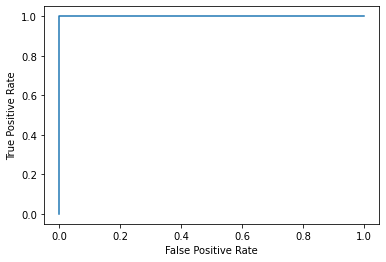

In [818]:

tree_function(MyNeuralNetwork(2, 15, 1, learning_rate=0.0001, activation_function=relu, epochs=10000), X_train, y_train, X_test, y_test, xx, yy)

(256, 128, 64, 32)
Czulosc: 1.0
Swoistosc: 1.0
Accuracy: 1.0
ROC auc: 1.0
F1 score: 1.0
BA score: 1.0


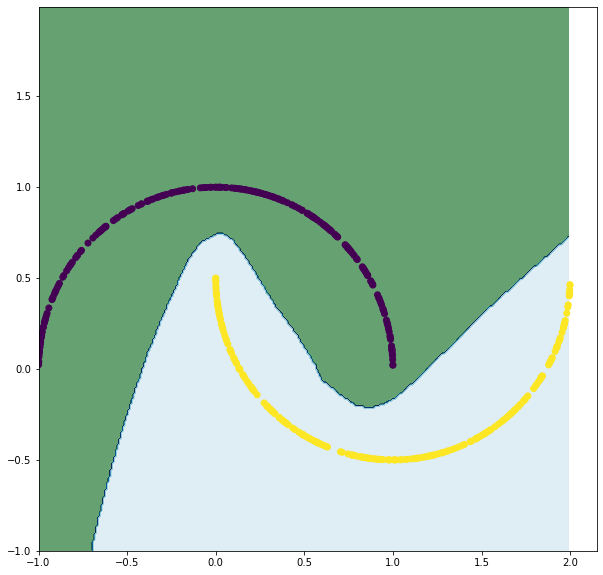

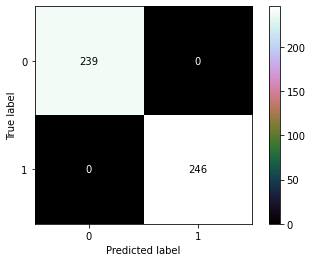

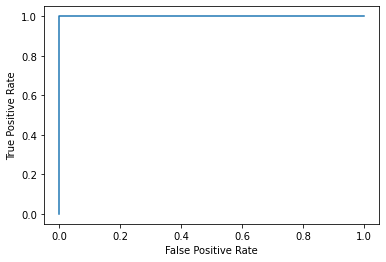

In [808]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', activation='relu', max_iter=1000, hidden_layer_sizes=(256, 128, 64, 32))
print(clf.hidden_layer_sizes)
tree_function(clf, X_train, y_train, X_test, y_test, xx, yy)